In [ ]:
# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

In [1]:
import os

import h5py
import numpy as np
import pandas as pd
import scipy.sparse as spp
import torch
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GATConv as pyg_GATConv
from torch_geometric.nn import global_max_pool

from utils import plot_losses, set_seed

In [2]:
def collate(samples):
    graphs1, dmaps1, graphs2, dmaps2, labels = map(list, zip(*samples))
    batch_g1 = Batch.from_data_list(graphs1)
    batch_g2 = Batch.from_data_list(graphs2)
    return batch_g1, pad_dmap(dmaps1), batch_g2, pad_dmap(
        dmaps2), torch.as_tensor(labels).float()


def pad_dmap(dmap_list):
    pad_dmap_tensors = torch.zeros((len(dmap_list), 1200, 13)).float()
    for idx, d in enumerate(dmap_list):
        # d = d.float().cpu()
        pad_dmap_tensors[idx] = torch.FloatTensor(d)
    # pad_dmap_tensors = pad_dmap_tensors.unsqueeze(1)
    return pad_dmap_tensors


class MyDataset(Dataset):
    def __init__(self, ids1, ids2, labels, cmap_dir, embedding_h5):
        super(MyDataset, self).__init__()
        self.ids1 = ids1
        self.ids2 = ids2
        self.labels = labels
        self.cmap_dir = cmap_dir
        self.embedding_h5 = embedding_h5
        self.embed_data = {}

        ids = set(ids1).union(set(ids2))
        with h5py.File(embedding_h5, "r") as h5fin:
            for id in ids:
                self.embed_data[id] = h5fin[id][:, :]

    def __getitem__(self, i):
        id1 = self.ids1[i]
        id2 = self.ids2[i]
        label = self.labels[i]
        cmap_file1 = os.path.join(self.cmap_dir, id1 + ".npz")
        cmap_file2 = os.path.join(self.cmap_dir, id2 + ".npz")
        g1, embed1 = self.loader(cmap_file1, id1)
        g2, embed2 = self.loader(cmap_file2, id2)
        return g1, embed1, g2, embed2, label

    def __len__(self):
        return len(self.ids1)

    def loader(self, cmap_file, id):
        embedding = self.embed_data[id]
        cmap_data = np.load(cmap_file)
        node_num = len(str(cmap_data["seq"]))
        cmap = cmap_data["contact"]
        g_embed = torch.as_tensor(embedding[:node_num]).float()

        adj = spp.coo_matrix(cmap)
        edge_index = torch.as_tensor(np.array([adj.row, adj.col]),
                                     dtype=torch.long)
        g = Data(x=g_embed, edge_index=edge_index)

        seq_len = embedding.shape[0]
        if seq_len > 1200:
            text_embed = embedding[:1200]
        elif seq_len < 1200:
            text_embed = np.concatenate(
                (embedding, np.zeros((1200 - seq_len, 13))))

        text_embed = torch.as_tensor(text_embed).float()

        return g, text_embed


class ConvLayer(nn.Module):
    def __init__(self, embed_dim):
        super(ConvLayer, self).__init__()
        self.embed_dim = embed_dim
        self.conv1 = nn.Conv1d(in_channels=self.embed_dim, out_channels=128,
                               kernel_size=3)
        self.mx1 = nn.MaxPool1d(3, stride=3)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3)
        self.mx2 = nn.MaxPool1d(3, stride=3)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3)
        self.mx3 = nn.MaxPool1d(130, stride=1)

    def forward(self, x):
        # x (N, L=1200, F=13)
        x = x.permute(0, 2, 1)  # N, F=13, L=1200
        features = self.conv1(x)  # N, F=128, L=1198
        features = self.mx1(features)  # N, F=128, L=399
        features = self.mx2(self.conv2(features))  # N, F=128, L=132
        features = self.conv3(features)  # N, F=128, L=130
        features = self.mx3(features)  # N, F=128, L=1
        features = features.squeeze(2)  # N, F=128
        return features


class GATPPI(nn.Module):
    def __init__(self, embed_dim, output_dim, dropout):
        super(GATPPI, self).__init__()
        self.embed_dim = embed_dim
        self.output_dim = output_dim
        self.drop = dropout

        # GAT layers with PyG
        self.gcn1 = pyg_GATConv(self.embed_dim, self.embed_dim, heads=3,
                                concat=True)
        self.gcn2 = pyg_GATConv(self.embed_dim * 3, self.embed_dim * 3, heads=3,
                                concat=True)
        self.gcn3 = pyg_GATConv(self.embed_dim * 9, self.embed_dim * 9, heads=1,
                                concat=True)
        self.relu = nn.ReLU()
        self.fc_g1 = nn.Linear(self.embed_dim * 9, self.output_dim)
        self.dropout = nn.Dropout(self.drop)

        # textcnn
        self.textcnn = ConvLayer(self.embed_dim)
        self.textflatten = nn.Linear(128, self.output_dim)

        # combined layers
        self.w1 = nn.Parameter(torch.FloatTensor([0.5]), requires_grad=True)
        self.fc1 = nn.Linear(self.output_dim * 2, 512)
        self.fc2 = nn.Linear(512, 256)
        self.out = nn.Linear(256, 1)

    def forward(self, g1, pad_dmap1, g2, pad_dmap2):
        # protein1
        x1 = self.relu(self.gcn1(g1.x, g1.edge_index))
        x1 = self.relu(self.gcn2(x1, g1.edge_index))
        x1 = self.relu(self.gcn3(x1, g1.edge_index))

        g1 = global_max_pool(x1, g1.batch)  # Global max pooling (N, 117)
        g1 = self.relu(self.fc_g1(g1))  # N, 128

        seq1 = self.textcnn(pad_dmap1)
        seq1 = self.relu(self.textflatten(seq1))  # N, 128

        w1 = torch.sigmoid(self.w1)
        gc1 = torch.add((1 - w1) * g1, w1 * seq1)  # N, 128

        # protein2
        x2 = self.relu(self.gcn1(g2.x, g2.edge_index))
        x2 = self.relu(self.gcn2(x2, g2.edge_index))
        x2 = self.relu(self.gcn3(x2, g2.edge_index))
        g2 = global_max_pool(x2, g2.batch)  # Global max pooling
        g2 = self.relu(self.fc_g1(g2))

        seq2 = self.textcnn(pad_dmap2)
        seq2 = self.relu(self.textflatten(seq2))

        gc2 = torch.add((1 - w1) * g2, w1 * seq2)

        # combine gc1 and gc2
        gc = torch.cat([gc1, gc2], dim=1)  # N, 256

        # add some dense layers
        gc = self.fc1(gc)
        gc = self.relu(gc)
        gc = self.dropout(gc)
        gc = self.fc2(gc)
        gc = self.relu(gc)
        gc = self.dropout(gc)
        out = self.out(gc)
        out = F.sigmoid(out)  # N, 1
        return torch.flatten(out)


In [3]:
spe = "yeast"

# data_dir = "ppi-data"
# train_file = os.path.join(data_dir, spe, "action/train_action_20.tsv")
# val_file = os.path.join(data_dir, spe, "action/test_action_20.tsv")
# epochs = 10

from google.colab import drive

drive.mount('/content/drive')
data_dir = "drive/MyDrive/ppi-data"
train_file = os.path.join(data_dir, spe, "action/train_action.tsv")
val_file = os.path.join(data_dir, spe, "action/test_action.tsv")
epochs = 50

batch_size = 32
dropout = 0.5
emb_dim = 13
output_dim = 128

lr = 0.001

set_seed(1234)

device = "cuda" if torch.cuda.is_available() else "cpu"

cmap_dir = os.path.join(data_dir, spe, "alphafold_cmap")
embedding_h5 = os.path.join(data_dir, spe, "seq/pipr.embedding.h5")

train_df = pd.read_csv(train_file, sep="\t", header=None)
train_dataset = MyDataset(train_df[0].to_list(), train_df[1].to_list(),
                          train_df[2].to_list(), cmap_dir, embedding_h5)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=collate,
    shuffle=True
)

val_df = pd.read_csv(val_file, sep="\t", header=None)
val_dataset = MyDataset(val_df[0].to_list(), val_df[1].to_list(),
                        val_df[2].to_list(), cmap_dir, embedding_h5)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=collate
)

model = GATPPI(emb_dim, output_dim, dropout)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [4]:

losses = []
val_losses = []

for epoch in range(epochs):
    batch_losses = []
    for g1, dmap1, g2, dmap2, y in train_loader:
        model.train()
        g1 = g1.to(device)
        g2 = g2.to(device)
        dmap1.to(device)
        dmap2.to(device)
        y = y.to(device)

        yhat = model(g1, dmap1, g2, dmap2)
        batch_loss = F.binary_cross_entropy(yhat, y)
        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        batch_losses.append(batch_loss.item())

    loss = np.mean(batch_losses)
    losses.append(loss)

    model.eval()
    with torch.no_grad():
        batch_losses = []
        n = 0
        accuracy_average = 0
        for g1, dmap1, g2, dmap2, y in val_loader:
            g1 = g1.to(device)
            g2 = g2.to(device)
            dmap1.to(device)
            dmap2.to(device)
            y = y.to(device)
            yhat = model(g1, dmap1, g2, dmap2)
            batch_loss = F.binary_cross_entropy(yhat, y)
            batch_losses.append(batch_loss.item())
            accuracy = accuracy_score(y.cpu(), (yhat.cpu() > 0.5).int())
            accuracy_average = (accuracy_average * n + accuracy * dmap1.shape[
                0]) / (n + dmap1.shape[0])
            n = n + dmap1.shape[0]

        val_loss = np.mean(batch_losses)
        val_losses.append(val_loss)

    print(
        f"Epoch: {epoch + 1} -- loss: {loss:.4f}, val_loss: {val_loss:.4f}, accuracy: {accuracy_average:.4f}")

Epoch: 1 -- loss: 0.6938, val_loss: 0.6932, accuracy: 0.5000
Epoch: 2 -- loss: 0.6893, val_loss: 0.6932, accuracy: 0.5000
Epoch: 3 -- loss: 0.6904, val_loss: 0.6931, accuracy: 0.5000
Epoch: 4 -- loss: 0.6938, val_loss: 0.6932, accuracy: 0.5000
Epoch: 5 -- loss: 0.6959, val_loss: 0.6933, accuracy: 0.5000
Epoch: 6 -- loss: 0.6865, val_loss: 0.6934, accuracy: 0.5000
Epoch: 7 -- loss: 0.6816, val_loss: 0.6934, accuracy: 0.5000
Epoch: 8 -- loss: 0.6904, val_loss: 0.6936, accuracy: 0.5000
Epoch: 9 -- loss: 0.6829, val_loss: 0.6934, accuracy: 0.5000
Epoch: 10 -- loss: 0.6709, val_loss: 0.6933, accuracy: 0.5000


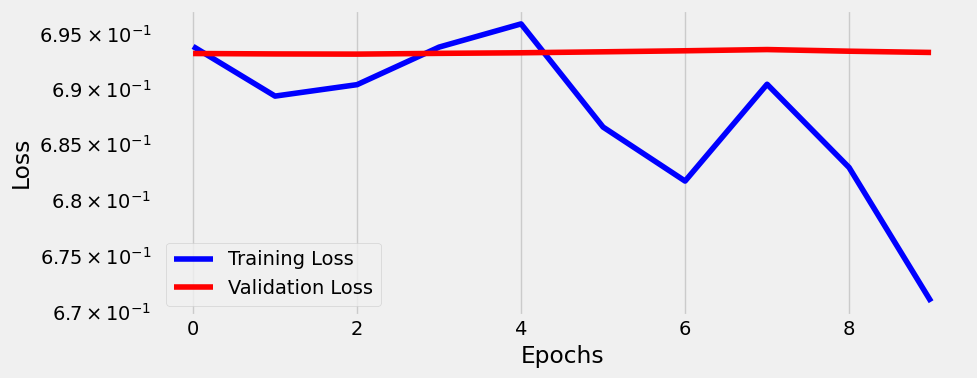

In [5]:
fig = plot_losses(losses, val_losses)